# 100 Years of Baseball
Andrew Moore

Baseball, called "America's Pastime" by many, is a favorite among sports statisticians. There is a decidicated community focused on analyzing advanced statistics for purposes of scouting, player development, or purely out of interest. The development of advanced statistics has been revolutionary for sports stastistics, and its development has implications for many sports outside of baseball, especially basketball and American football.  
  
Another Unique aspect of Baseball is its longevity and profound influence on American culture. In this analysis, we will examine baseball not from the viewpoint of advanced statistics but through a temporal lens. How has baseball changed over time? Can we find unique, players, or umpires, or games through statistics that have been otherwise lost to time. 

**Contents**
1. Data Loading and Management 
   * [Imports](#imports)
   * [Data Loading](#data-loading)
   * [Loading Dataset from Github](#loading-dataset-from-github)
   * [Memory Management](#memory-management-and-column-dtypes)
   * [Dataset Annotation](#dataset-aggregation-and-further-annotation)
2. [Home Field Advantage](#home-field-advantage)
3. [Are Umpires Really that bad?](#are-umps-really-that-bad)
4. [Baseball Scorigami](#baseball-scorigami)
5. [Baseball Games through Time](#baseball-over-time)

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.cm as cm
import umap.umap_ as umap
from IPython.display import Markdown

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

Unfortunately, the original dataset I planned to work with was improperly assembled from the raw csv files, resulting in many missing rows. I still like the column names, so we will use those from that csv, but we will build the DataFrame from scratch using the individual year game log files. Assembling the dataset like this is fairly computationally expensive, so the folowing code has been commented out, and the assembled dataset is loaded from github. The raw csvs used can be found here: [Retrosheet](https://retrosheet.org/gamelogs/). 

In [2]:
# data_dir = './data'

In [3]:
# col_names = pd.read_csv(os.path.join(data_dir, 'game_logs.csv'), nrows=0).columns
# col_names

In [4]:
# data_raw = pd.DataFrame()

# for year in range(1871, 2024):
#     year_df = pd.read_csv(f"./data/gl1871_2023/gl{str(year)}.txt", header=None)
#     data_raw = pd.concat([data_raw, year_df])
    
# del year_df

# data_raw.columns = col_names

In [5]:
# data_raw['v_line_score'] = data_raw['v_line_score'].astype('str') # Parquet doesn't play nice with integer-like object types in pandas.
# data_raw['h_line_score'] = data_raw['h_line_score'].astype('str')
# data_raw.to_parquet('./public_data/MLB_gl1871_2023.parquet.gzip', compression='gzip')

In [6]:
# data_raw.info(memory_usage='deep')

## Loading Dataset from Github  

Our compressed parquet object is fairly small (~25 MB), so we can store it on github directly. 

In [7]:
data_raw = pd.read_parquet('https://github.com/moore-andrew05/MLB-ds/raw/main/public_data/MLB_gl1871_2023.parquet.gzip')
data_raw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 1.1 GB


## Memory Management and Column dtypes
This object is manageable in size (~1.2GB), but we would like to reduce it. We could optimize some of our numerical columns, but we will get much more memory optimization from converting our `object` columns to `categorical`. 

The memory usage of a `Categorical` is proportional to the number of categories plus the length of the data. In contrast, an `object` dtype is a constant times the length of the data - [Pandas Documentation](https://pandas.pydata.org/docs/user_guide/categorical.html#categorical-memory). Because of this, we will use the categorical dtype only when the number of unique values is significantly smaller than the number of total values. 

In addition to this, we need to consider whether a categorical datatype makes sense for the data in each column as well as the limitations of the pandas categorical type. Mainly, categorical columns are not compatible with numpy, so we will have to take that into account. 

Here are our `object` columns:

In [8]:
pd.set_option('display.max_columns', 100)
data_obj = data_raw.select_dtypes(include=["object"]).copy()
data_obj.describe()

day_of_week  v_name v_league  h_name h_league day_night  \
count       228779  228779   227698  228779   227698    208491   
unique           7     150        6     150        6         2   
top            Sat     CHN       NL     CHN       NL         D   
freq         38137   10961   116993   11132   117005    114377   

              completion forefeit protest park_id v_line_score h_line_score  \
count                189      149     273  228779       228779       228779   
unique               189        3       5     258        49235        47812   
top     19190727,,0,2,36        H       V   BOS07          nan          nan   
freq                   1       70     134    8771        18578        18578   

       hp_umpire_id hp_umpire_name 1b_umpire_id 1b_umpire_name 2b_umpire_id  \
count        228763         228766       203923         228766       144687   
unique         1346           1340          894            893          555   
top        klemb901      Bill Klem     connt901         (none)     westj901   
freq           3544           3544         2025          24843         1326   

       2b_umpire_name 3b_umpire_id 3b_umpire_name lf_umpire_id lf_umpire_name  \
count          228143       173593         228143          208         228769   
unique            556          608            608           36             37   
top            (none)     westj901         (none)     sudoe901         (none)   
freq            83456         1398          54550           30         228561   

       rf_umpire_id rf_umpire_name v_manager_id v_manager_name h_manager_id  \
count            14         228769       228779         228779       228779   
unique           13             14          727            727          740   
top        gormt101         (none)     mackc101    Connie Mack     mackc101   
freq              2         228755         3898           3898         3846   

       h_manager_name winning_pitcher_id winning_pitcher_name  \
count          228779             207660               207660   
unique            740               6870                 6806   
top       Connie Mack           johnw102       Walter Johnson   
freq             3846                417                  417   

       losing_pitcher_id losing_pitcher_name saving_pitcher_id  \
count             207660              207660             74829   
unique              7536                7460              4283   
top             ryann001       Dutch Leonard          rivem002   
freq                 292                 295               652   

       saving_pitcher_name winning_rbi_batter_id winning_rbi_batter_id_name  \
count               208482                176417                     208482   
unique                4263                  7829                       7717   
top                 (none)              pujoa001                     (none)   
freq                133653                   328                      32065   

       v_starting_pitcher_id v_starting_pitcher_name h_starting_pitcher_id  \
count                 228735                  228735                228735   
unique                  6365                    6313                  6318   
top                 younc102              Don Sutton              younc102   
freq                     403                     375                   412   

       h_starting_pitcher_name v_player_1_id   v_player_1_name v_player_2_id  \
count                   228735        208482            208482        208482   
unique                    6276          3847              3806          4831   
top                 Nolan Ryan      hendr001  Rickey Henderson      fox-n101   
freq                       412          1447              1447           852   

       v_player_2_name v_player_3_id v_player_3_name v_player_4_id  \
count           208482        208482          208482        208482   
unique            4767          3939            3904          3485   
top         Nellie Fox     

Some columns are obvious candidates for the categorical dtype, such as `day_of_week` and `day_night`. Thinking about the content of other columns, the `v_line_score` and `h_line_score` columns stick out, as they represent the box score (runs scored in each inning by both teams). It doesn't make much sense to represent these as categorical data. I will not make extensive use of them in this analysis, but if using them, it would be best to either create a custom dtype for this data or to represent the score for each inning as its own column in the DataFrame. 

The big question mark is our player name data. The ratio of unique values to total length for these columns is about 0.03, and there are a lot of columns representating player name and id, so we will see large memory savings by converting these columns. However, we will make extensive use of these columns in network analysis, so it may be easier to work with them as object columns. For now, we will convert them to categorical. 

In [9]:
data_obj.drop(columns=['v_line_score', 'h_line_score'], inplace=True)   # Drop v_line and h_line columns
data_obj = data_obj.astype('category')                                  # Convert remaining columns to categorical 

In [10]:
data_opt = data_raw.copy()
data_opt[data_obj.columns] = data_obj
del data_obj                                                            # data_obj no longer needed

In [11]:
print('Optimized DataFrame')
print(data_opt.info(memory_usage='deep'))
print('\nOriginal DataFrame')
print(data_raw.info(memory_usage='deep'))

Optimized DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), float64(77), int64(6), object(2)
memory usage: 232.9 MB
None

Original DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 1.1 GB
None


We now have an optimized dataframe where all but 2 of our object columns have been converted to categorical dtypes. Our optimized dataframe takes up 5 times less space with this change!

The last step in cleaning our columns is our date column. This is not a memory saving measure, but we will want to convert our date to a more usable format. Luckily, Pandas gives us a tool for this, the `datetime` type. 

In [12]:
date_col = data_opt['date']
data_opt['date'] = pd.to_datetime(date_col, format="%Y%m%d")
data_opt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), datetime64[ns](1), float64(77), int64(5), object(2)
memory usage: 232.9 MB


## Dataset Aggregation and Further Annotation

In [13]:
data_opt['winning_margin'] = (data_opt['h_score'] - data_opt['v_score']).apply(np.abs)
data_opt['total_score'] = data_opt['h_score'] + data_opt['v_score']

In [14]:
eras_dict = {                                           # We map each game to an era based on when it was played. 
    '1871-01-01': 'Pre-History (1871-1900)',
    '1901-01-01': 'Dead Ball Era (1901-1920)',
    '1921-01-01': 'Live Ball Era (1921-1942)',
    '1943-01-01': 'Integration Era (1943-1961)',
    '1962-01-01': 'Expansion Era (1962-1977)',
    '1978-01-01': 'Free Agent Era (1978-1994)',
    '1995-01-01': 'Steroid Era (1995-2004)',
    '2005-01-01': 'Contemporary Era (2005-Present)'
}

dates = sorted(pd.to_datetime(key) for key in eras_dict.keys())
labels = [eras_dict[str(date.date())] for date in dates]
bins = dates + [pd.Timestamp('today')]

In [15]:
# Feature Creation: We will use these features later to cluster our games, we want the total values for each game, which we
# calculate by summing the home and visitor stats for each feature. 
aggregate_stats = ['length_outs', 'total_score', 'winning_margin', 'hits', 'doubles', 'triples', 'homeruns', 'rbi', 'walks', 'strikeouts', 'stolen_bases', 'errors', 'double_plays']

for feature in aggregate_stats[3:]:
    c1 = f'v_{feature}'
    c2 = f'h_{feature}'
    data_opt[feature] = data_opt[c1] + data_opt[c2]

era = pd.cut(data_opt['date'], bins=bins, labels=labels, right=False, include_lowest=True)
era_mapping = pd.DataFrame(era)
era_mapping.rename(columns={'date':'era'}, inplace=True)
era_mapping['date'] = data_opt['date']
era_mapping = era_mapping.drop_duplicates().set_index('date')
data_opt['era'] = era

## Home Field Advantage

In [16]:
home_field = data_opt.loc[data_opt.loc[:,'winning_margin'] != 0].copy(deep=False)

In [17]:
# This csv contains information about our team ids, we will create mappings from team id to League and City/Nickname

teams = pd.read_csv('https://raw.githubusercontent.com/moore-andrew05/MLB-ds/main/public_data/teams.csv')
teams['CITY_NICKNAME'] = teams['CITY'] + ' - ' + teams['NICKNAME'] + f' (' + teams['TEAM'] + ')'
team_league_mapper = teams.set_index('TEAM')['LEAGUE'].to_dict()
team_nickname_mapper = teams.set_index('TEAM')['CITY_NICKNAME'].to_dict()

In [18]:
# This csv contains information about our ballparks, we will create mappings to make them more readable. 

parks = pd.read_csv('https://raw.githubusercontent.com/moore-andrew05/MLB-ds/main/public_data/ballparks.csv')
parks['CURRENT'] = ~parks['START'].isna() & parks['END'].isna()
parks['CITY-NAME'] = parks['CITY'] + ' - ' + parks['NAME'] + ' (' + parks['PARKID'] + ')'
parks.loc[parks['CITY-NAME'].isna(), 'CITY-NAME'] = parks['PARKID'].where(parks['CITY-NAME'].isna())
parks_mapper = parks.set_index('PARKID')['CITY-NAME'].to_dict()

In [19]:
home_field.loc[:, 'home_win'] = home_field['h_score'] > home_field['v_score']
home_field.loc[home_field['h_score'] > home_field['v_score'], 'w_team'] = home_field['h_name'][home_field['h_score'] > home_field['v_score']].astype('object')
home_field.loc[home_field['h_score'] < home_field['v_score'], 'w_team'] = home_field['v_name'][home_field['h_score'] < home_field['v_score']].astype('object')
home_field.loc[home_field['h_score'] > home_field['v_score'], 'l_team'] = home_field['v_name'][home_field['h_score'] > home_field['v_score']].astype('object')
home_field.loc[home_field['h_score'] < home_field['v_score'], 'l_team'] = home_field['h_name'][home_field['h_score'] < home_field['v_score']].astype('object')
home_field['w_team'] = home_field['w_team'].astype('category')
home_field['l_team'] = home_field['l_team'].astype('category')
home_field['w_team_league'] = home_field['w_team'].map(team_league_mapper)
home_field['l_team_league'] = home_field['l_team'].map(team_league_mapper)
home_field['w_team_nickname'] = home_field['w_team'].map(team_nickname_mapper)
home_field['l_team_nickname'] = home_field['l_team'].map(team_nickname_mapper)

In [20]:
gb_hf = home_field.set_index('date').groupby(pd.Grouper('date', freq='YE'))

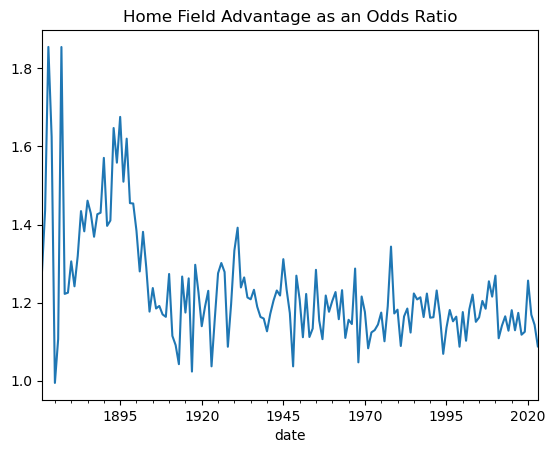

In [21]:
home_win_percentage = gb_hf['home_win'].sum() / gb_hf['home_win'].size()
visit_win_percentage = 1 - home_win_percentage
odds = home_win_percentage / visit_win_percentage
(odds).plot(title='Home Field Advantage as an Odds Ratio');

This graph is quite striking. Aside from the early years of baseball where this metric was still stabilizing, the odds ratio of home win probability to away win probability is 1.2:1. This means that if two completely equal teams play 22 times, the home team will be expected win 12 times. Especially in modern baseball, where all stadiums are the same, this is quite an advantage!  
  
We can also look at home win differential split out by team:

In [22]:
w_team_gb = home_field.groupby('w_team', observed=True)
l_team_gb = home_field.groupby('l_team', observed=True) 

# Home record
home_wins = w_team_gb['home_win'].sum()
home_losses = l_team_gb.size() - l_team_gb['home_win'].sum()
home_percentage = ((home_wins / (home_wins + home_losses))).where(home_wins+home_losses > 500).dropna() # Filter on teams with at least 500 home games
home_percentage.index = home_percentage.index.map(team_nickname_mapper)
home_percentage.name = 'Home Win Percentage'

# Away Record
away_wins = w_team_gb.size() - w_team_gb['home_win'].sum()
away_losses = l_team_gb['home_win'].sum()
away_percentage = ((away_wins / (away_wins + away_losses))).where(away_wins+away_losses > 500).dropna() # Filter on teams with at least 500 away games
away_percentage.index = away_percentage.index.map(team_nickname_mapper)
away_percentage.name = 'Away Win Percentage'

win_differential = home_percentage - away_percentage
win_differential.name = 'Home/Away Win Differential'
display(Markdown(win_differential.sort_values(ascending=False)[:10].to_markdown()))

|                                |   Home/Away Win Differential |
|:-------------------------------|-----------------------------:|
| Washington - Senators (WSN)    |                     0.245066 |
| Louisville - Colonels (LS2)    |                     0.243727 |
| Cleveland - Spiders (CL4)      |                     0.221252 |
| Baltimore - Orioles (BLN)      |                     0.215074 |
| Philadelphia - Athletics (PH4) |                     0.196358 |
| Louisville - Colonels (LS3)    |                     0.174051 |
| St. Louis - Cardinals (SL4)    |                     0.156058 |
| Colorado - Rockies (COL)       |                     0.148592 |
| Boston - Braves (BSN)          |                     0.11304  |
| Houston - Astros (HOU)         |                     0.106696 |

The teams with the greatest home/away differential among teams with at least 500 home games and 500 away games have about a 25% difference between their home and away records! Our own Colorado Rockies make the list, with a ~15% differential between home and away win percentages. 

In [23]:
stadium_gb = home_field.groupby('park_id', observed=True)
stadium_wins = stadium_gb['home_win'].sum()
stadium_losses = stadium_gb.size() - stadium_wins
stadium_percentage = (stadium_wins / (stadium_gb.size())).where(stadium_gb.size() > 500) # Only select stadiums where at least 500 games have been played. 
current_percentages = stadium_percentage[parks.set_index('PARKID')['CURRENT']]
stadium_percentage.index = stadium_percentage.index.map(parks_mapper)
current_percentages.index = current_percentages.index.map(parks_mapper)
stadium_percentage.name = 'Home Win Percentage'
current_percentages.name = 'Home Win Percentage'
display(Markdown(stadium_percentage.sort_values(ascending=False)[:5].to_markdown()))

| park_id                                         |   Home Win Percentage |
|:------------------------------------------------|----------------------:|
| STL03                                           |              0.698727 |
| Baltimore - Oriole Park III (BAL07)             |              0.690635 |
| Boston - South End Grounds I (BOS01)            |              0.672059 |
| Philadelphia - Columbia Park (PHI10)            |              0.664395 |
| Philadelphia - Jefferson Street Grounds (PHI01) |              0.64011  |

This is quite a simplistic view of ballpark winrates, and it will be highly correlated with good teams. In order to view the effect of the ballpark itself, we would have to account for the winrate differential of the teams that played there. Unfortunately, our pallparks data is not fully annotated with the teams that played in each stadium, and because most stadiums only house one team as the home team, it would likely still look similar to the win differentials we calculated by team. 

We can also look at the best and worst modern stadiums in terms of win percentage:

In [24]:
display(Markdown(current_percentages.sort_values(ascending=False)[:5].to_markdown()))
display(Markdown(current_percentages.sort_values()[:5].to_markdown()))

| park_id                               |   Home Win Percentage |
|:--------------------------------------|----------------------:|
| New York - Yankee Stadium II (NYC21)  |              0.619742 |
| Los Angeles - Dodger Stadium (LOS03)  |              0.580577 |
| St. Louis - Busch Stadium III (STL10) |              0.579473 |
| Atlanta - Truist Park (ATL03)         |              0.578641 |
| Boston - Fenway Park (BOS07)          |              0.570317 |

| park_id                                         |   Home Win Percentage |
|:------------------------------------------------|----------------------:|
| Miami - Marlins Park (MIA02)                    |              0.481928 |
| Baltimore - Oriole Park at Camden Yards (BAL12) |              0.498801 |
| Pittsburgh - PNC Park (PIT08)                   |              0.500553 |
| Detroit - Comerica Park (DET05)                 |              0.501323 |
| Cincinnati - Great American Ballpark (CIN09)    |              0.506991 |

Finally, let's examine the home/away differential for teams within the two modern leagues: the National League and the American League.

In [25]:
dh_diff = home_field[(home_field['date'] > '1973-01-01') & (home_field['date'] < '2023-01-01') & (home_field['date'].dt.year != 2020)]
dh_w_team_gb = dh_diff.groupby('w_team', observed=True)
dh_l_team_gb = dh_diff.groupby('l_team', observed=True) 

# Home record
home_wins = dh_w_team_gb['home_win'].sum()
home_losses = dh_l_team_gb.size() - dh_l_team_gb['home_win'].sum()
home_percentage = ((home_wins / (home_wins + home_losses))).where(home_wins+home_losses > 500).dropna() # Filter on teams with at least 500 home games

# Away Record
away_wins = dh_w_team_gb.size() - dh_w_team_gb['home_win'].sum()
away_losses = dh_l_team_gb['home_win'].sum()
away_percentage = ((away_wins / (away_wins + away_losses))).where(away_wins+away_losses > 500).dropna() # Filter on teams with at least 500 away games

home_percentage_al = home_percentage.where(home_percentage.index.map(team_league_mapper) == 'AL').dropna()
home_percentage_nl = home_percentage.where(home_percentage.index.map(team_league_mapper) == 'NL').dropna()
away_percentage_al = away_percentage.where(away_percentage.index.map(team_league_mapper) == 'AL').dropna()
away_percentage_nl = away_percentage.where(away_percentage.index.map(team_league_mapper) == 'NL').dropna()
al_diff = home_percentage_al - away_percentage_al
nl_diff = home_percentage_nl - away_percentage_nl
print(f'National League Home Differential: {np.round(nl_diff.mean(), 3)}')
print(f'American League Home Differential: {np.round(al_diff.mean(), 3)}')

National League Home Differential: 0.081
American League Home Differential: 0.073


Indeed, we do observe a difference in National vs American League home differentials. National League teams have a better home win differential. If we think about the implications of the designated hitter rule, this result makes sense. National League pitchers had more experience hitting during that period due to interleague play, and I posit that it would be easier for National League teams to manage an extra league average designated hitter on their roster than to teach their pitchers to hit.  
  
It should be noted that this difference is fairly small, and we would want to quanitfy it will effect size analysis at the least, but we have spent enough time here. 

## Are Umps Really that Bad?

The bane of many baseball fans is the home plate umpire. Are home plate umpires really that different from each other, and can we identify the 'worst' umpires from baseball history? To do this, we will analyze each umpire by examining the difference in the walks and strikeouts they call compared to the average stats from the time period in which they umpired. We will quantify these difference using cohen's d, which is an effect size measure. 

In [26]:
umpire_df = data_opt.loc[:, ['date', 'hp_umpire_id', 'strikeouts', 'walks']].copy()
umpire_df[['strikeouts', 'walks']] = umpire_df[['strikeouts', 'walks']].replace(-2.0, np.nan).replace(-1.0, np.nan)
umpire_df = umpire_df.dropna()
umpire_df['hp_umpire_id'] = umpire_df['hp_umpire_id'].astype('object') # Due to the way that categories work after filtering, we don't want to deal with them here

In [27]:
gb = umpire_df.groupby('hp_umpire_id', observed=True)                       # Group by umpires
umpire_mean_stats = gb[['strikeouts', 'walks']].mean()[gb.size() > 20]      # Find average strikeout and walks in games officiated by each umpire

In [28]:
umpire_mean_stats['first_game'] = gb['date'].min()            # Find the date range for each umpire
umpire_mean_stats['last_game'] = gb['date'].max()

In [29]:
def cohens_d(u1, s1, n1, u2, s2, n2):
    pooled_sd = np.sqrt(((n1 - 1) * np.power(s1, 2) + (n2 - 1) * np.power(s2, 2)) / (n1 + n2 - 2))
    return (u1 - u2) / pooled_sd

def calc_mean_std_size(p):
    return np.mean(p), np.std(p), len(p)

def get_populations(umpire, stat):
    p1 = umpire_df[(umpire_df['date'] >= umpire_mean_stats.loc[umpire, 'first_game']) & (umpire_df['date'] <= umpire_mean_stats.loc[umpire, 'last_game']) & (umpire_df['hp_umpire_id'] != umpire)][stat]
    p2 = umpire_df[umpire_df['hp_umpire_id'] == umpire][stat]
    return p1, p2

In [30]:
pops_strikeouts = umpire_mean_stats.index.to_series().apply(get_populations, args=('strikeouts',)) # This code is slow, could be improved
pops_walks = umpire_mean_stats.index.to_series().apply(get_populations, args=('walks',))

In [31]:
umpire_mean_stats['effect_size_strikeouts'] = pd.Series(pd.DataFrame(pops_strikeouts.to_list()).apply(lambda x: cohens_d(*calc_mean_std_size(x[0]), *calc_mean_std_size(x[1])), axis=1)).values
umpire_mean_stats['effect_size_walks'] = pd.Series(pd.DataFrame(pops_walks.to_list()).apply(lambda x: cohens_d(*calc_mean_std_size(x[0]), *calc_mean_std_size(x[1])), axis=1)).values

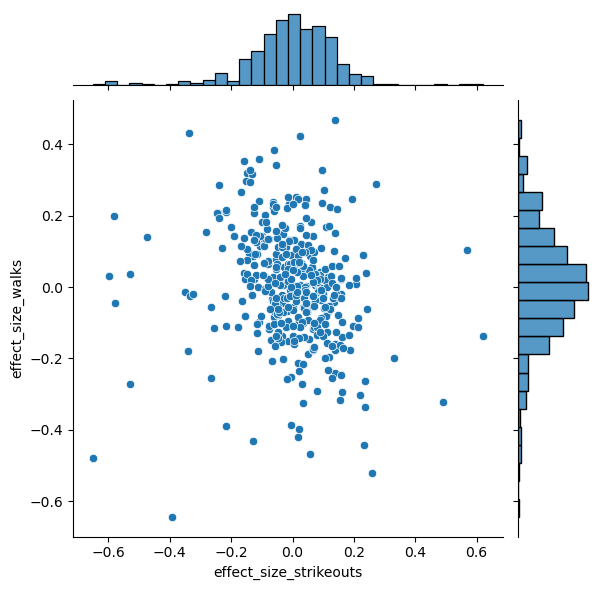

In [32]:
sns.jointplot(data=umpire_mean_stats, x='effect_size_strikeouts', y='effect_size_walks');

This jointplot looks as we would expect. Each point represents the effect size of walks and strikeouts for an individual umpire. Both are normally distributed about effect_size=0. Still, we can identify some umpires which generally call more/less strikeouts, walks, or both. To give us more information, we can color this plot by the number of games each individual umpire officiated.

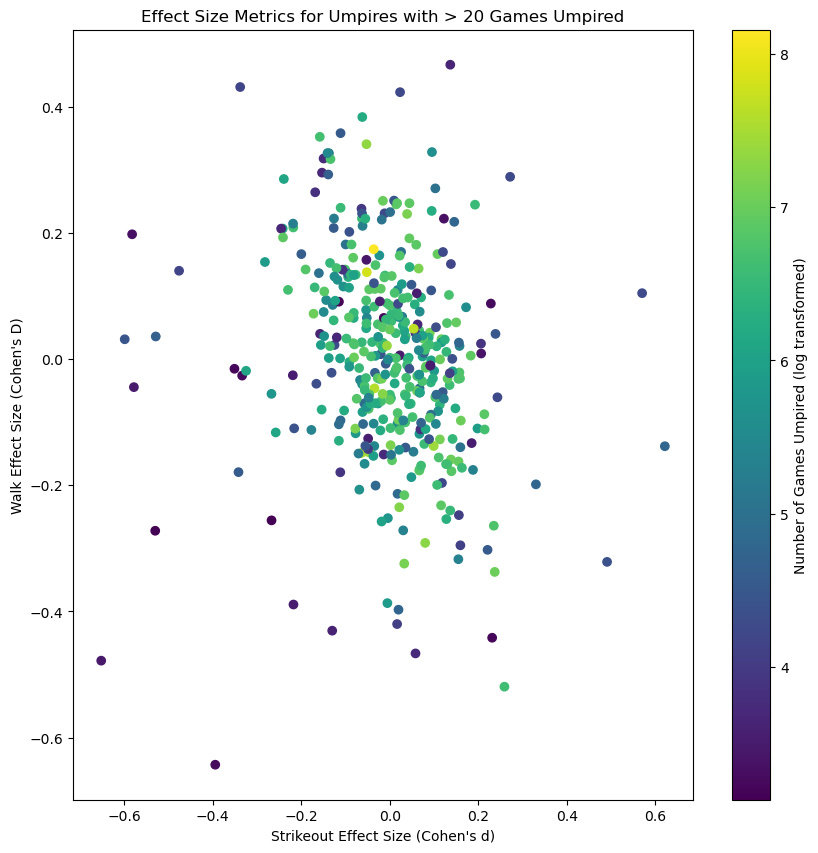

In [33]:
umpire_mean_stats['num_games'] = gb.size()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
colorm3 = ax.scatter(x=umpire_mean_stats['effect_size_strikeouts'], y=umpire_mean_stats['effect_size_walks'], c=np.log(umpire_mean_stats['num_games']+1))
ax.set_xlabel("Strikeout Effect Size (Cohen's d)")
ax.set_ylabel("Walk Effect Size (Cohen's D)")
ax.set_title('Effect Size Metrics for Umpires with > 20 Games Umpired')
fig.colorbar(colorm3, label='Number of Games Umpired (log transformed)');

In [34]:
umpire_mean_stats[umpire_mean_stats['num_games'] > 250].sort_values(by='effect_size_walks',ascending=False)

strikeouts     walks first_game  last_game  \
hp_umpire_id                                               
byrol901        7.379310  4.659229 1913-05-24 1919-09-26   
eddid901       15.387179  5.433333 1998-08-18 2023-09-29   
quige901        6.506614  5.021164 1913-06-25 1936-09-13   
harrp901        6.217391  4.619565 1916-05-23 1920-10-03   
millb901       15.210719  5.548112 1997-08-01 2023-09-23   
...                  ...       ...        ...        ...   
owenb901        6.320637  6.955679 1908-09-17 1937-10-02   
morig101        6.123894  7.209976 1917-05-22 1940-09-29   
cousd901       11.281690  7.654049 1979-04-06 2012-09-09   
basis901        7.014245  8.128205 1936-04-19 1942-09-25   
hurle901        8.473046  8.652291 1947-04-21 1965-09-29   

              effect_size_strikeouts  effect_size_walks  num_games  
hp_umpire_id                                                        
byrol901                   -0.061874           0.384278        493  
eddid901                   -0.157823           0.352892        780  
quige901                   -0.052446           0.341212       1512  
harrp901                    0.095470           0.328704        276  
millb901                   -0.133692           0.317589        821  
...                              ...                ...        ...  
owenb901                    0.080147          -0.291245       1444  
morig101                    0.032893          -0.324080       1243  
cousd901                    0.237223          -0.337249       1136  
basis901                   -0.005212          -0.386746        351  
hurle901                    0.259132          -0.519322        742  

[254 rows x 7 columns]

#### Interesting Umpires
There are some points which stick out on this graph, especially those with medium effect sizes and a large amount of games umpired. 

##### Lord Byron (Not the Poet)
The point at (-0.06, 0.38) is Lord Byron, who umpired from 1913-1919, and was also known as the singing umpire.   
![Lord Byron](https://upload.wikimedia.org/wikipedia/en/b/bd/William_%22Lord%22_Byron_%28baseball_umpire%29.jpg)  
  
It is rumored that whenever a batter struck out looking, he would recite the following:   
  
"Let me tell you something, friend  
Before you grow much older  
You cannot improve your average, Sir  
With the bat upon your shoulder."  
  
Lord Byron was apparently stingy in handing out walks.

##### Doug Eddings
The point at (-0.15, 0.35) is Doug Eddings, a modern ump who debuted in 1998. With a propensity to call less walks than the average umpire, it is no surprise that a report in the hardball times reported that he had the largest strike zone in MLB in 2011 [(source)](https://tht.fangraphs.com/which-umpire-has-the-largest-strikezone/)  
  
<img src="https://upload.wikimedia.org/wikipedia/commons/c/ce/Doug_Eddings.jpg" width="300"/>


## Baseball Scorigami  
  
Scorigami is a very popular curiosity in American football. It represents all the unique score that have ever occured. What if we repeat this idea for baseball games?

In [35]:
def make_scorigami_frame(df):
    game_scores = df['h_score'].astype('str') +'-'+ df['v_score'].astype('str')
    scorigami_data = pd.DataFrame(game_scores.unique(), columns=['score'])
    scorigami_data[['h_score','v_score']] = pd.DataFrame(scorigami_data['score'].str.split('-').tolist(), index=scorigami_data.index).astype('int')
    scorigami_data.set_index('score', inplace=True)
    scorigami_data['counts'] = game_scores.value_counts(sort=False)

    return scorigami_data

def make_scorigami_pivot(df):
    scorigami_pivot = df.pivot(index='v_score', columns='h_score', values='counts').fillna(0)
    scorigami_pivot.sort_index(axis=1, inplace=True)
    oohs = np.zeros((50, 50))
    oohs = pd.DataFrame(oohs)
    oohs.index.name = 'v_score'
    oohs.columns.name = 'h_score'
    oohs.loc[scorigami_pivot.index, scorigami_pivot.columns] = scorigami_pivot
    return oohs

In [36]:
scorigami_data = make_scorigami_frame(data_opt)
scorigami_pivot = make_scorigami_pivot(scorigami_data)

In [37]:
# Define Custom Colormap
cmap = plt.cm.plasma
num_bins = 14
colors = cmap(np.linspace(0, 1, num_bins))
colors[0] = np.array([0, 0, 0, 1], dtype=float) # We want to be able to easily distinguish 1s and 0s. 
cmap = LinearSegmentedColormap.from_list("inferno", colors, N=num_bins)
boundaries = [0,1,2,4,8,16,32,64,128,256,512,1024, 2048, 4096, 8192]
norm=pltc.BoundaryNorm(boundaries, cmap.N, clip=True)

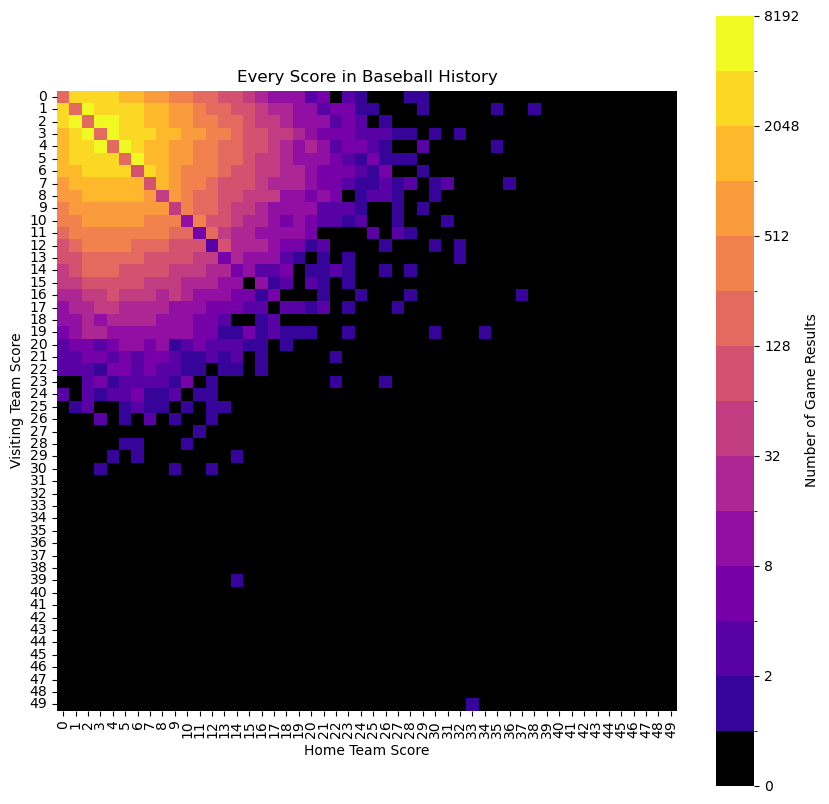

In [38]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = sns.heatmap(scorigami_pivot, cmap=cmap, norm=norm, square=True, xticklabels=scorigami_pivot.index.values, yticklabels=scorigami_pivot.index.values, cbar_kws={'label':'Number of Game Results'})
ax.set_title('Every Score in Baseball History')
ax.set_xlabel('Home Team Score')
ax.set_ylabel('Visiting Team Score');

This plot looks as we would expect. Most games result in a reasonable score, (3-2 is a very common score), but there are some extremes. One 1871 game featured a 49-33 score, an impossibility in today's game! One pattern we notice is a low abundance of games along the diagonal axis. These games represent ties, which are a rarity in baseball. Let's look at the distribution of these ties over time! 

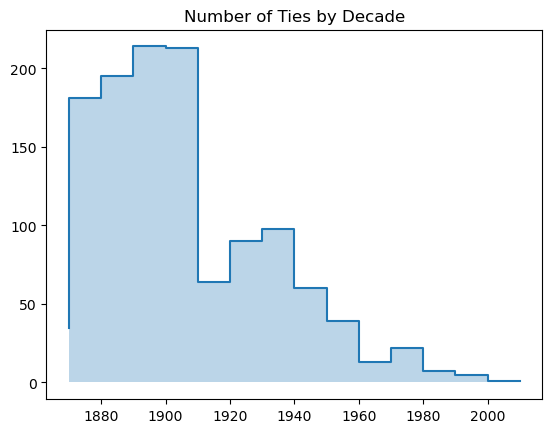

In [39]:
ties = data_opt[data_opt['winning_margin'] == 0]
decade_ties = ties.groupby((ties.set_index('date').index.year//10) * 10).size()
plt.fill_between(x=decade_ties.index, y1=decade_ties, alpha=0.3, step='pre')
plt.plot(decade_ties, drawstyle='steps')
plt.title('Number of Ties by Decade');

In [40]:
ties.iloc[-1]['date']

Timestamp('2016-09-29 00:00:00')

I can't fully explain the first drop off which occured around 1910. I would suspect it is due to the general organization of baseball at the time. Pre-1900s baseball was very disorganized, and ties may have occured as a result. The drop off from 1920-1960 is very telling, as it directly coincides with the implementation of night games in Major League Baseball. Lighting allowed for teams to play into the night, which allowed for games to go longer and for ties to be resolved. We observe almost no ties in the 2000s, and the last tie was in 2016. 

## Baseball Over Time

### Low-dimensional embedding with UMAP and HDBSCAN Clustering  
  
We want to quantify games and cluster them on a variety of metrics. In this case, we have 13 dimensions that we track for each game. Clustering algorithms generally don't scale to larger dimensions due to the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Because of this, we need to reduce the dimensionality of the data to apply a clustering algorithm (in this case HDBSCAN). We could use a more primitive technique such as PCA, but I have tested this and it does not work well for this data. Instead we can apply [UMAP](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection), which preserves both the local and the global structure of the data. We can then cluster in 5 dimensions and visualize in 2 dimensions. 

In [41]:
# Feature Selection
def create_features_targets(features=['length_outs', 'total_score', 'winning_margin', 'hits', 'doubles', 'triples', 'homeruns', 'rbi', 'walks', 'strikeouts', 'stolen_bases', 'errors', 'double_plays'], grouped=None, filter_pre_history=False):
    feature_data = data_opt.loc[:, ['date', *features]].copy()
    if filter_pre_history:
        feature_data = feature_data[feature_data['date'] > '1900-01-01']
    if grouped is not None:
        # To get a more consistent view of our features, we can aggregate our data 
        feature_data = feature_data.set_index('date').groupby(pd.Grouper('date', freq=grouped)).mean()
        feature_data = feature_data.reset_index()
    feature_data = pd.merge(feature_data.set_index('date'), era_mapping, how='inner', on='date')
    feature_data = feature_data.dropna()
    X = feature_data.loc[:, features].values
    y = feature_data.loc[:, 'era'].values
    return feature_data, X, y

In [42]:
feature_df, X, y = create_features_targets(grouped='D', filter_pre_history=True)
X.shape, y.shape

((21040, 13), (21040,))

In [43]:
# Feature Scaling
X = StandardScaler().fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=0.85, svd_solver='full')
pcs = pca.fit_transform(X)

principal_df = pd.DataFrame(pcs, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
feature_df = pd.concat([feature_df, principal_df.set_index(feature_df.index)], axis=1)

cluster_embedding = umap.UMAP(
    n_neighbors=90,
    min_dist=0.0,
    n_components=5,
).fit_transform(X)
cluster_embedding.shape

reducer = umap.UMAP()
viz_embedding = reducer.fit_transform(X)
viz_embedding.shape

for component in range(cluster_embedding.shape[1]):
    feature_df[f'cluster_umap_{component + 1}'] = cluster_embedding[:, component]

    feature_df['umap_1'] = viz_embedding[:, 0]
feature_df['umap_2'] = viz_embedding[:, 1]

hdbscan = HDBSCAN(
    min_samples=5,
    min_cluster_size=500,
)
hdbscan_labels = hdbscan.fit_predict(cluster_embedding)
feature_df['hdbscan_labels'] = hdbscan_labels

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


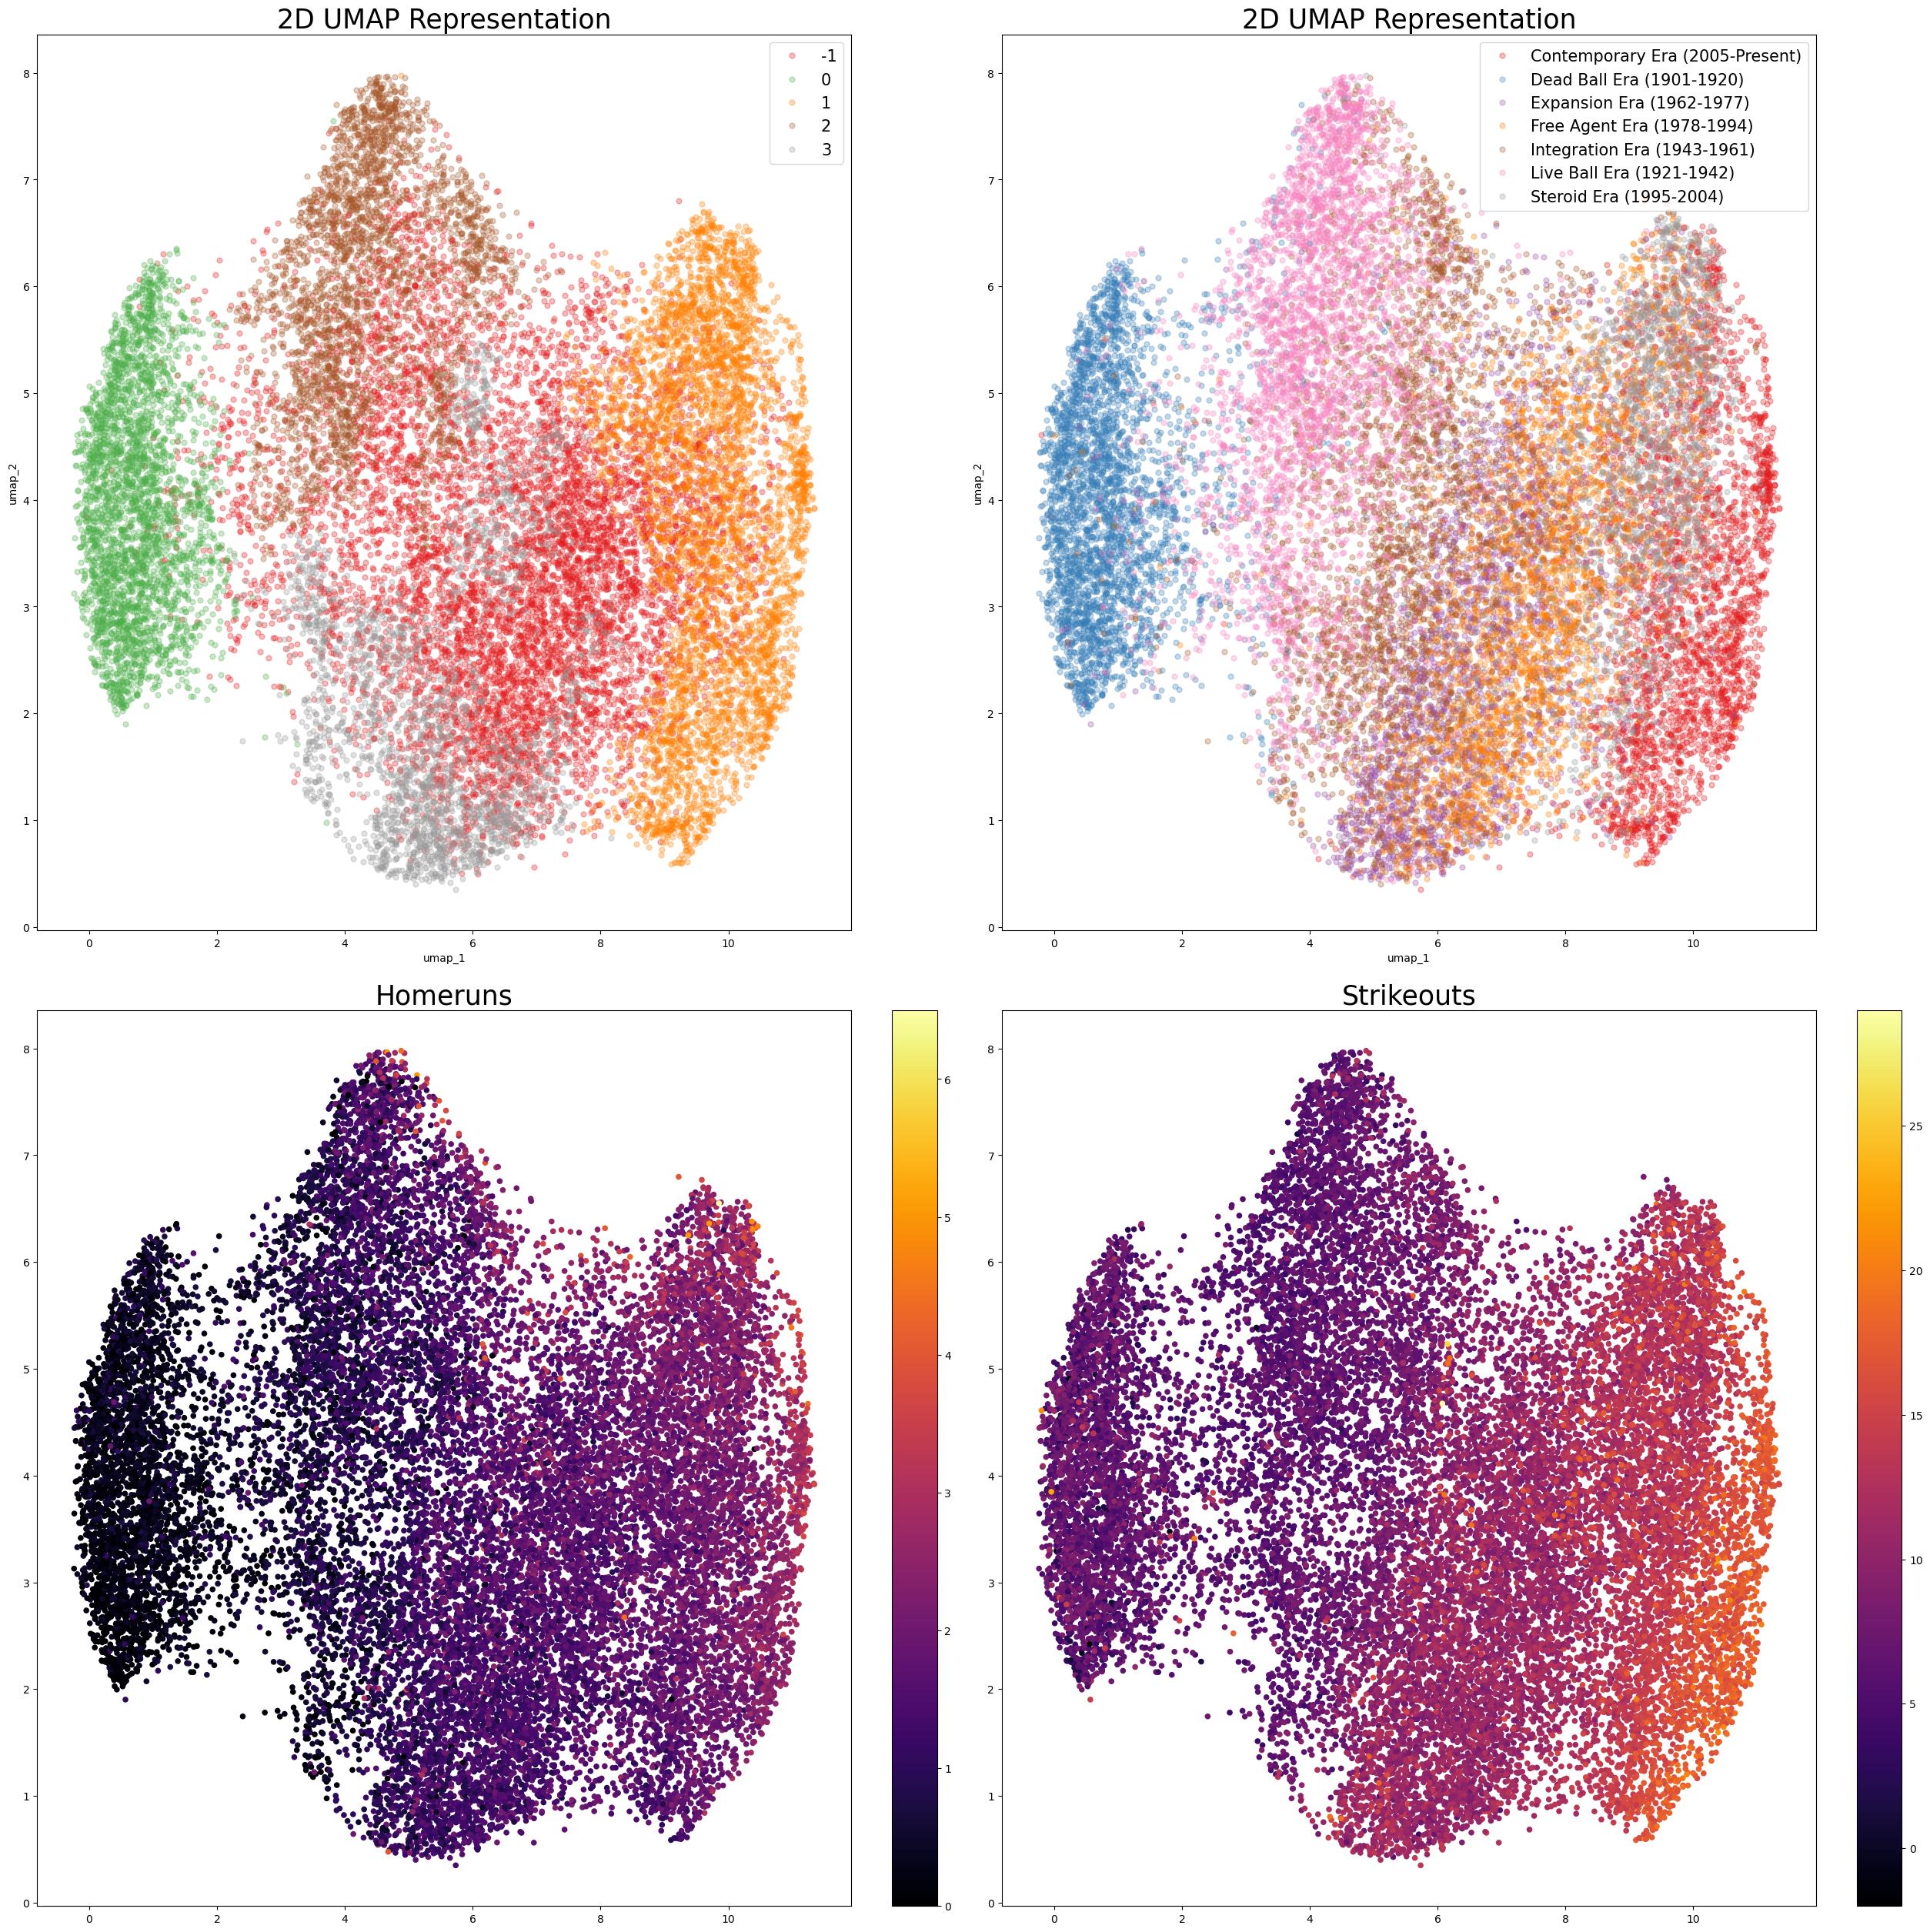

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(25,25), layout='constrained')


for pc in range(2):
    targets = np.unique(hdbscan_labels) if pc == 0 else np.unique(y)
    label_col = 'hdbscan_labels' if pc==0 else 'era'
    clrs = cm.Set1(np.linspace(0,1,len(targets)))
    axes[0][pc].set_title(f'2D UMAP Representation', fontsize=25)
    axes[0][pc].set_xlabel(f'umap_1')
    axes[0][pc].set_ylabel(f'umap_2')

    for t, c in zip(targets, clrs):
        rows_idx = feature_df.loc[:, label_col] == t
        axes[0][pc].plot(feature_df.loc[rows_idx, f'umap_1'],
                feature_df.loc[rows_idx, f'umap_2'],
                'o',
                c=c, alpha=0.3, markersize=5)
    axes[0][pc].legend(targets, fontsize=15)

colorm = axes[1][0].scatter(x=feature_df.loc[:, f'umap_1'], y=feature_df.loc[:, f'umap_2'], c=feature_df['homeruns'], cmap='inferno', s=20)
axes[1][0].set_title('Homeruns', fontsize=25)
fig.colorbar(colorm, ax=axes[1][0])
colorm2 = axes[1][1].scatter(x=feature_df.loc[:, f'umap_1'], y=feature_df.loc[:, f'umap_2'], c=feature_df['strikeouts'], cmap='inferno', s=20)
axes[1][1].set_title('Strikeouts', fontsize=25)
fig.colorbar(colorm2, ax=axes[1][1]);

When aggregating the data by day, our 2D UMAP representation shows that the variation in statistics over time is very continuous. Distant eras are quite distinct, but eras close in temporal space blend together, with one major exception. The Dead Ball Era, a time where pitchers could throw spitballs and coat baseballs in mud, is very distinct. If we label the points with homeruns and strikeouts, we see why this era is distinct. Our first panel is our clustering labels, where noise points are red. Dead ball era games form a very distinct cluster, as do steroid era and contemporary games. Most of the other eras blend together. 

In [45]:
feature_df, X, y = create_features_targets(grouped='W', filter_pre_history=True)
X.shape, y.shape

((3081, 13), (3081,))

In [46]:
# Feature Scaling
X = StandardScaler().fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=0.85, svd_solver='full')
pcs = pca.fit_transform(X)

principal_df = pd.DataFrame(pcs, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
feature_df = pd.concat([feature_df, principal_df.set_index(feature_df.index)], axis=1)

cluster_embedding = umap.UMAP(
    n_neighbors=90,
    min_dist=0.0,
    n_components=5,
).fit_transform(X)
cluster_embedding.shape

reducer = umap.UMAP()
viz_embedding = reducer.fit_transform(X)
viz_embedding.shape

for component in range(cluster_embedding.shape[1]):
    feature_df[f'cluster_umap_{component + 1}'] = cluster_embedding[:, component]

    feature_df['umap_1'] = viz_embedding[:, 0]
feature_df['umap_2'] = viz_embedding[:, 1]

hdbscan = HDBSCAN(
    min_samples=5,
    min_cluster_size=500,
)
hdbscan_labels = hdbscan.fit_predict(cluster_embedding)
feature_df['hdbscan_labels'] = hdbscan_labels

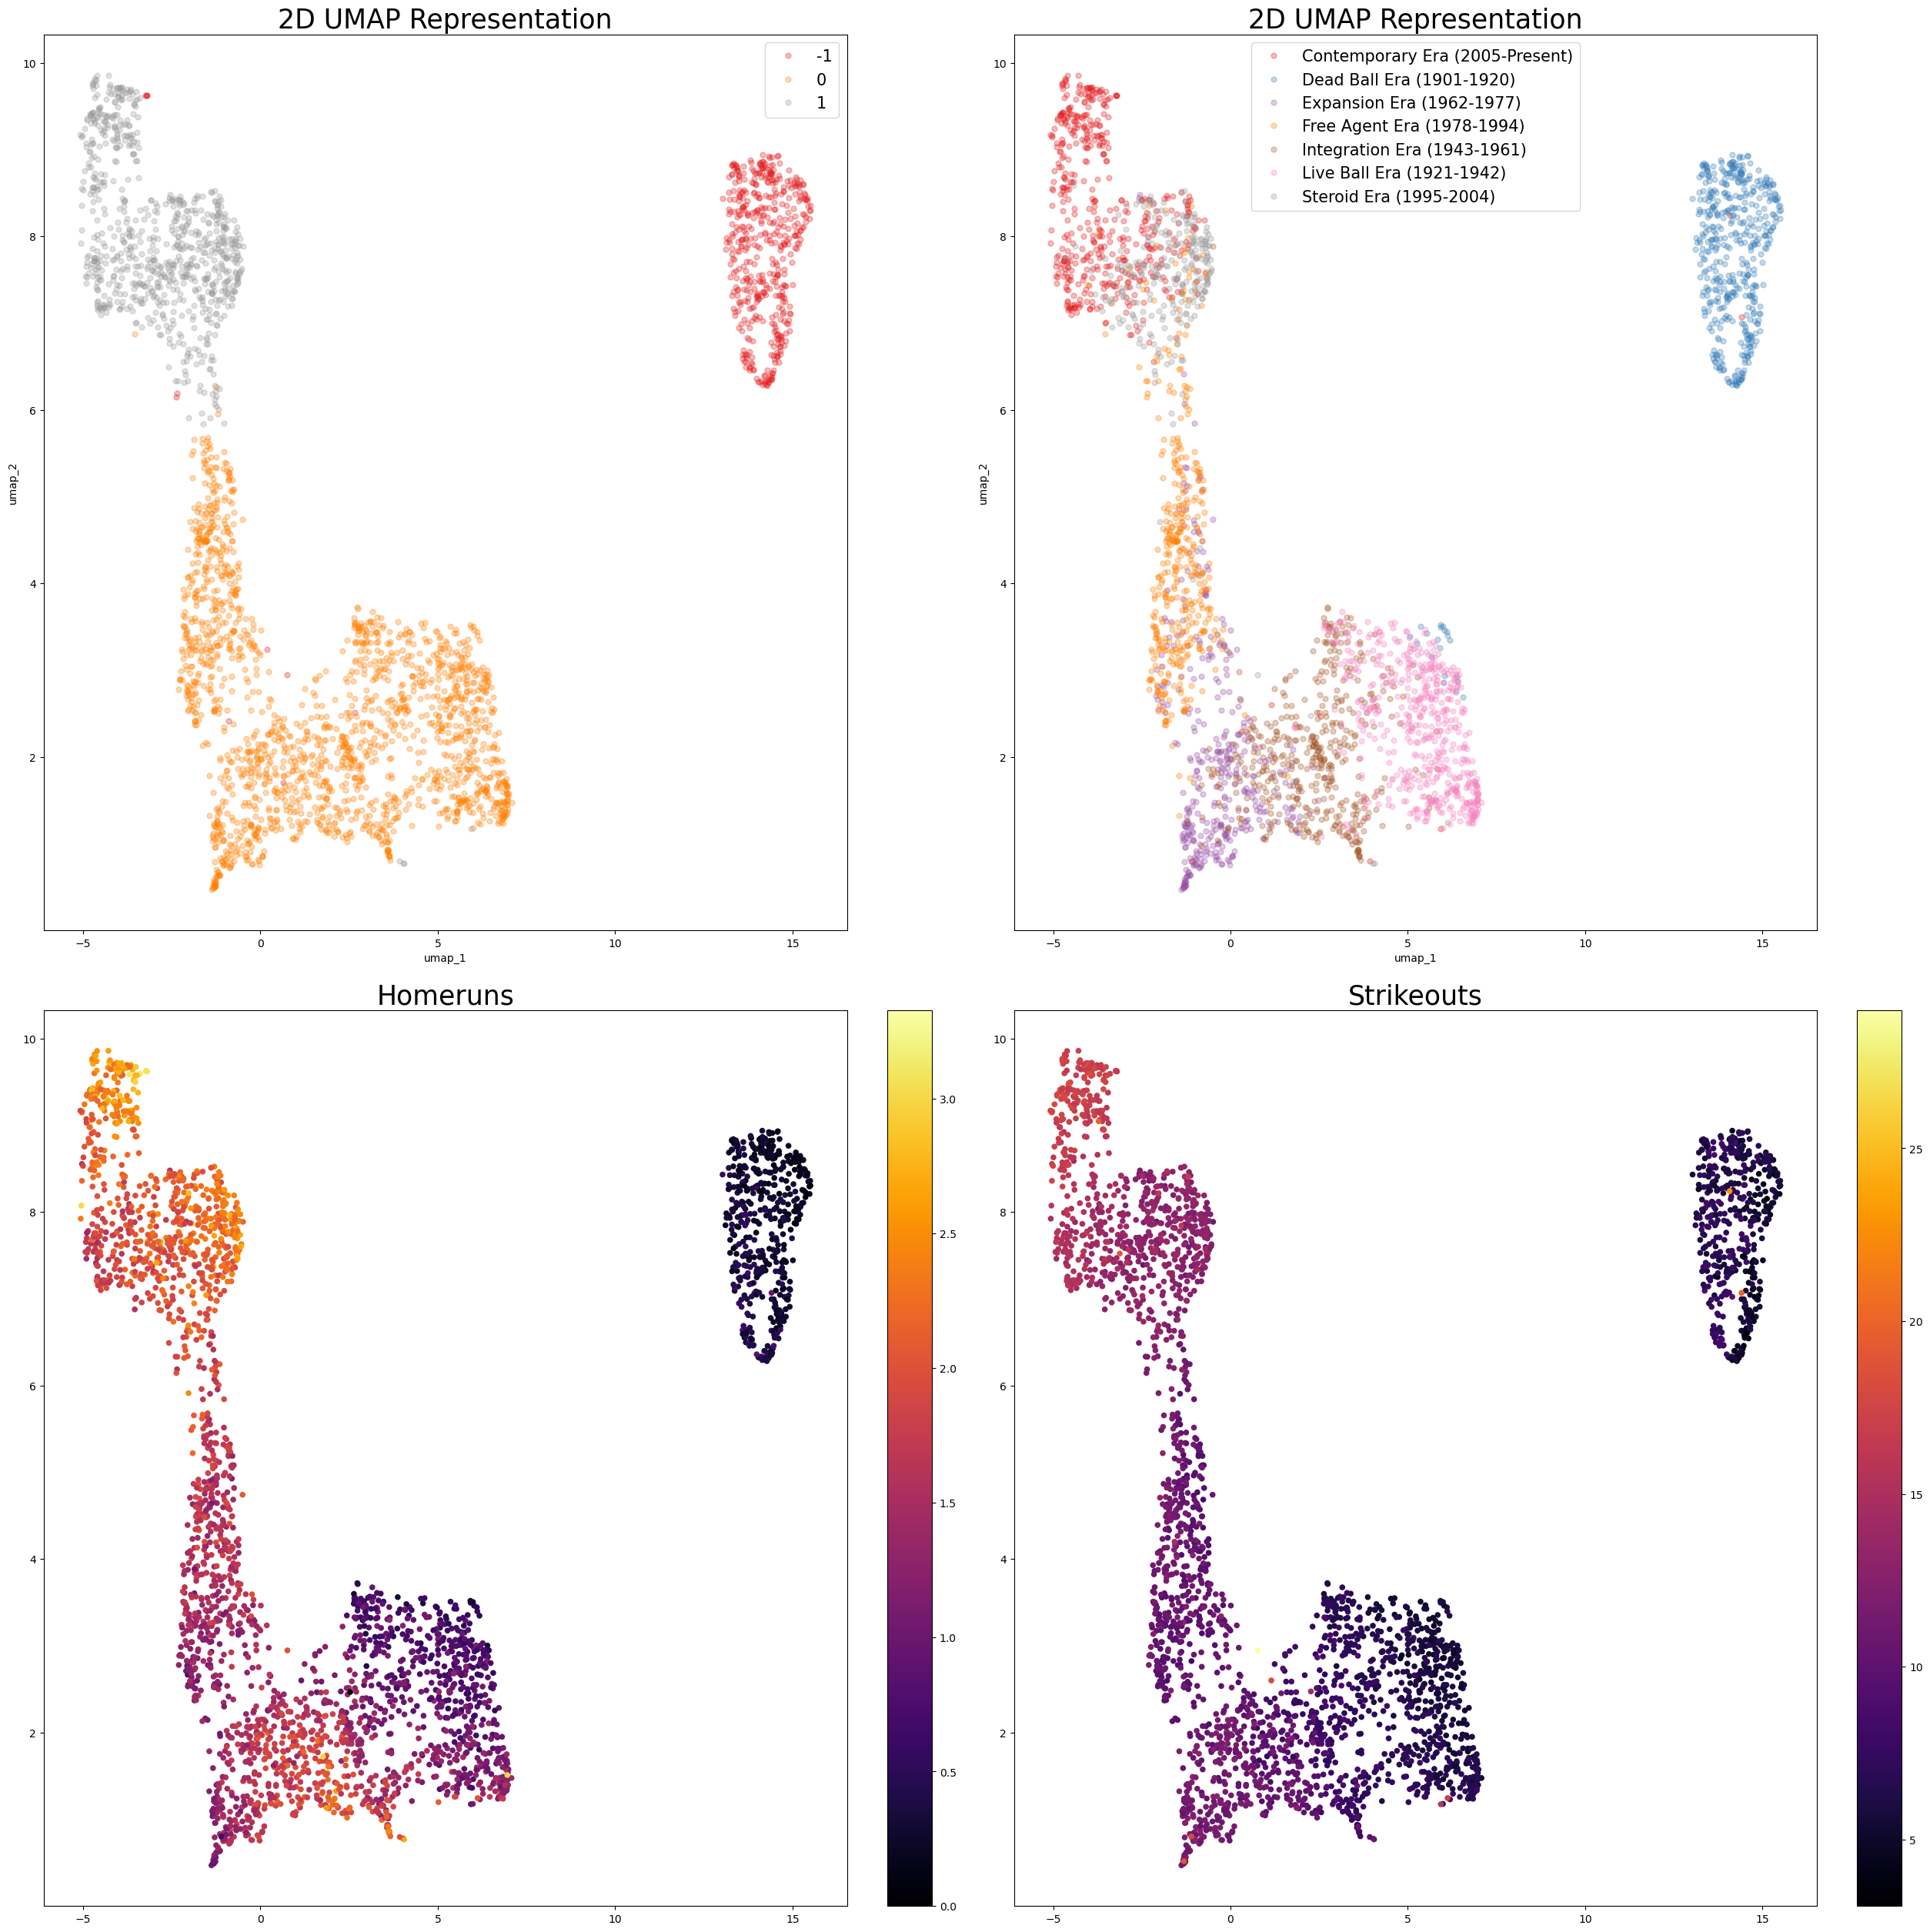

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(25,25), layout='constrained')


for pc in range(2):
    targets = np.unique(hdbscan_labels) if pc == 0 else np.unique(y)
    label_col = 'hdbscan_labels' if pc==0 else 'era'
    clrs = cm.Set1(np.linspace(0,1,len(targets)))
    axes[0][pc].set_title(f'2D UMAP Representation', fontsize=25)
    axes[0][pc].set_xlabel(f'umap_1')
    axes[0][pc].set_ylabel(f'umap_2')

    for t, c in zip(targets, clrs):
        rows_idx = feature_df.loc[:, label_col] == t
        axes[0][pc].plot(feature_df.loc[rows_idx, f'umap_1'],
                feature_df.loc[rows_idx, f'umap_2'],
                'o',
                c=c, alpha=0.3, markersize=5)
    axes[0][pc].legend(targets, fontsize=15)

colorm = axes[1][0].scatter(x=feature_df.loc[:, f'umap_1'], y=feature_df.loc[:, f'umap_2'], c=feature_df['homeruns'], cmap='inferno', s=20)
axes[1][0].set_title('Homeruns', fontsize=25)
fig.colorbar(colorm, ax=axes[1][0])
colorm2 = axes[1][1].scatter(x=feature_df.loc[:, f'umap_1'], y=feature_df.loc[:, f'umap_2'], c=feature_df['strikeouts'], cmap='inferno', s=20)
axes[1][1].set_title('Strikeouts', fontsize=25)
fig.colorbar(colorm2, ax=axes[1][1]);

If we cluster based on weekly aggregate statistics, the patterns we observed previously are even more striking. Dead Ball Era games are even more distinct, while the contemporary/steroid cluster is tigher than in the daily aggregation. 